# ACNets: Attentional Control Networks
## Hyper-parameters tuning

In this notebook, we explore all the possible decisions that can be made when preprocessing and training a classifier for AVGP vs. NVGPs using functional connectivities.

Parameter space includes preprocessing steps, connectivity matrices, and hyper-parameters for the classifier. Here are the hyper-parameters that we are exploring:

- Preprocessing
  - high-pass and low-pass filtering
  - parcellation atlases
  - binarization
  - binarization threshold
  - connectivity measures
  - diagonal connectivity
  - factor analysis
  - include only inter-network connectivities/factors

## Setup

In [1]:
%reload_ext autoreload
%autoreload 3

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns; sns.set('notebook')

from sklearn import preprocessing, model_selection, metrics, ensemble
from sklearn import decomposition, cross_decomposition, feature_selection, dummy, svm

from sklearn.pipeline import Pipeline

from nilearn import datasets as nilean_datasets

import skopt
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from factor_analyzer import ConfirmatoryFactorAnalyzer, ModelSpecificationParser

from python.acnets.pipeline import Parcellation, ConnectivityExtractor
from python.acnets.pipeline import ConnectivityVectorizer


from copy import deepcopy

from tqdm import tqdm


# Technical reproducibility
%reload_ext watermark
%watermark -iv -co -ituhmv

Last updated: 2022-03-08T18:03:01.435262+01:00

Python implementation: CPython
Python version       : 3.9.10
IPython version      : 8.0.1

conda environment: acnets

Compiler    : Clang 11.1.0 
OS          : Darwin
Release     : 21.3.0
Machine     : x86_64
Processor   : i386
CPU cores   : 12
Architecture: 64bit

Hostname: MP0159

seaborn   : 0.11.2
matplotlib: 3.5.1
sys       : 3.9.10 | packaged by conda-forge | (main, Feb  1 2022, 21:28:27) 
[Clang 11.1.0 ]
numpy     : 1.21.5
pandas    : 1.4.0
nilearn   : 0.9.0
skopt     : 0.9.0
sklearn   : 1.0.2



In [61]:
participants = pd.read_csv('data/julia2018/participants.tsv', sep='\t')
participants = participants.query('preprocessed_rsfmri == True')
X = participants['participant_id'].apply(lambda x: x.split('-')[1]).values
y = participants['group'].values
# X,y

In [114]:
# Setup the classifier pipeline and hyper-parameter tuning search


pipe = Pipeline([
  ('parcellation', Parcellation()),
  ('extractor', ConnectivityExtractor()),
  ('vectorizer', ConnectivityVectorizer()),
  ('zv', feature_selection.VarianceThreshold()),
  ('classifier', svm.SVC(probability=True))
])

param_space = {
  'extractor__kind': Categorical(
    ['correlation', 'tangent'], #'chatterjee'],
    transform='label'),
  'vectorizer__discard_diagonal': Categorical(
    [True, False],
    transform='label'),
  'classifier__C': Real(1e-3, 1e3, 'log-uniform'),
  'classifier__kernel': Categorical(
    ['linear', 'rbf'],
    transform='label'),
}

opt_cv = model_selection.StratifiedKFold(5)
opt = BayesSearchCV(
  pipe, param_space, cv=opt_cv,
  # n_jobs=1,
  verbose=0,
  n_points=2,
  # n_iter=10,
  scoring='accuracy')

split = model_selection.StratifiedShuffleSplit(n_splits=10, test_size=0.2)
# FIXME DEBUG train, test = next(split.split(X, y))

for train, test in split.split(X, y):
  model = opt.fit(X[train], y[train])
  print(model.best_estimator_)
  train_score = model.score(X[train], y[train])
  test_score = model.score(X[test], y[test])
  
  print(f'Score (train/test): {train_score:.3f}/{test_score:.3f}')

Pipeline(steps=[('parcellation', Parcellation()),
                ('extractor', ConnectivityExtractor()),
                ('vectorizer', ConnectivityVectorizer(discard_diagonal=True)),
                ('zv', VarianceThreshold()),
                ('classifier',
                 SVC(C=0.030229914843454737, kernel='linear',
                     probability=True))])
Score (train/test): 0.880/0.571
Pipeline(steps=[('parcellation', Parcellation()),
                ('extractor', ConnectivityExtractor(kind='tangent')),
                ('vectorizer', ConnectivityVectorizer()),
                ('zv', VarianceThreshold()),
                ('classifier', SVC(C=78.75022484447594, probability=True))])
Score (train/test): 1.000/0.286
Pipeline(steps=[('parcellation', Parcellation()),
                ('extractor', ConnectivityExtractor(kind='tangent')),
                ('vectorizer', ConnectivityVectorizer(discard_diagonal=True)),
                ('zv', VarianceThreshold()),
                ('classifie

KeyboardInterrupt: 

## Data

X is a 2D matrix of size (n_subjects, n_features), where features are the connectivity measures, e.g., correlation.

We first load the data and preprocess it, i.e., binarize the X.

## Confirmatory factor analysis
Now, we programmatically define the factor model. Factor model is a dictionary that maps latent factors, i.e., brain networks, to the observable variables, i.e., node features within the brain networks.

We then fit the factor model to the data and extract the factor loadings.

In [5]:

factors_model = dict.fromkeys(X.columns.levels[0], [])

for k,v in X.columns:
  factors_model[k] = factors_model[k] + [v]

print('networks:', list(factors_model.keys()))

networks: ['cerebellum', 'cingulo-opercular', 'default', 'fronto-parietal', 'occipital', 'sensorimotor']


The factor model analyzer uses SciPy optimizer under the hood. It's slow for our data, so we limit the features to those within the networks and discard intra-network connections. This will produce a dataset of 118 features.

In [6]:
X_df = X
if FIT_ONLY_INTER_NETWORK_CONNECTIVITIES:
  _inter_network_cols = ~X.columns.get_level_values(0).str.contains("↔")

  _control_networks = [
    'cerebellum', 'cingulo-opercular', 'fronto-parietal',
    'default', 'sensorimotor', 'occipital']

  _control_networks_cols = X.columns.get_level_values(0).isin(_control_networks)

  X_df = X.loc[:,(_inter_network_cols & _control_networks_cols,)]
  
  #TODO remove unwanted networks from factors_model
  
  factors_model = {
    k:v for k,v in factors_model.items() if k in X_df.columns.get_level_values(0).unique().to_list()
  }

In [190]:
print('Number of features per network:')
{k:len(v) for k,v in factors_model.items()}
factors_model

Number of features per network:


{'cerebellum': ['inf cerebellum 110',
  'med cerebellum 120',
  'med cerebellum 144',
  'inf cerebellum 131',
  'inf cerebellum 140',
  'med cerebellum 127',
  'med cerebellum 138',
  'med cerebellum 143',
  'lat cerebellum 109',
  'inf cerebellum 121',
  'inf cerebellum 122',
  'inf cerebellum 155',
  'inf cerebellum 150',
  'inf cerebellum 151',
  'med cerebellum 130',
  'lat cerebellum 113',
  'lat cerebellum 128',
  'lat cerebellum 98'],
 'cingulo-opercular': ['ACC 19',
  'basal ganglia 30',
  'basal ganglia 38',
  'post insula 76',
  'precuneus 87',
  'fusiform 81',
  'basal ganglia 39',
  'mFC 31',
  'thalamus 57',
  'vFC 40',
  'sup temporal 100',
  'mid insula 59',
  'basal ganglia 71',
  'TPJ 125',
  'aPFC 8',
  'parietal 89',
  'mid insula 44',
  'dACC 27',
  'ant insula 26',
  'angular gyrus 102',
  'ant insula 28',
  'temporal 78',
  'parietal 97',
  'thalamus 58',
  'mid insula 61',
  'vFC 33',
  'vPFC 18',
  'temporal 103',
  'vFC 25',
  'thalamus 47',
  'temporal 95',
  

In [8]:
print(f'Now fitting CFA to our data of size {X_df.shape}')

Now fitting CFA to our data of size (32, 160)


In [9]:
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo

# Adequacy Test

# X_norm = preprocessing.StandardScaler().fit_transform(X_df)

chi2_value, chi2_pvalue = calculate_bartlett_sphericity(X_df)
kmo_all, kmo_total_score = calculate_kmo(X_df)

print(
  'chi2 (p-value): {} ({})\n'
  'kmo total score: {}'.format(chi2_value, chi2_pvalue, kmo_total_score)
)

chi2 (p-value): -inf (1.0)
kmo total score: nan


/usr/local/Caskroom/miniforge/base/envs/acnets/lib/python3.9/site-packages/factor_analyzer/factor_analyzer.py:111: RuntimeWarning: divide by zero encountered in log
  statistic = -np.log(corr_det) * (n - 1 - (2 * p + 5) / 6)


In [10]:
factors_spec = ModelSpecificationParser.parse_model_specification_from_dict(X_df, factors_model)


cfa = ConfirmatoryFactorAnalyzer(factors_spec, disp=False)

X_norm = X_df # DEBUG preprocessing.StandardScaler().fit_transform(X_df)
X_cfa = cfa.fit_transform(X_norm)

In [11]:
print('Now tuning the classifier for X_cfa of size', X_cfa.shape)

Now tuning the classifier for X_cfa of size (32, 6)


### Evaluate the factor model

Extracted latent features can not be used for prediction.

The following cell perform a permutation test to contrast observed and random scores (ROC AUC).

In [12]:
cv = model_selection.RepeatedStratifiedKFold(n_splits=5, n_repeats=10)

# test/train splits
train, test = model_selection.train_test_split(
  X_cfa,
  test_size=0.2,
  shuffle=True,
  stratify=y,)


# model fitting
try:
  progress_bar = tqdm(total=opt.total_iterations)
  opt.fit(
    X_cfa, y,
    callback = [
      skopt.callbacks.DeadlineStopper(total_time=120),
      lambda _: False if progress_bar.update() else False,
  ])
finally:
  progress_bar.clear()
  progress_bar.close()


# permutation testing
obs_score, rnd_scores, obs_pvalue = model_selection.permutation_test_score(
  opt.best_estimator_,
  X_cfa, y,
  cv=cv,
  n_permutations=100,
  scoring='roc_auc')

print('Observed score (p-value): {:.3f} ({:.3f})'.format(obs_score, obs_pvalue))

100%|██████████| 50/50 [00:27<00:00,  1.83it/s]


Observed score (p-value): 0.789 (0.030)


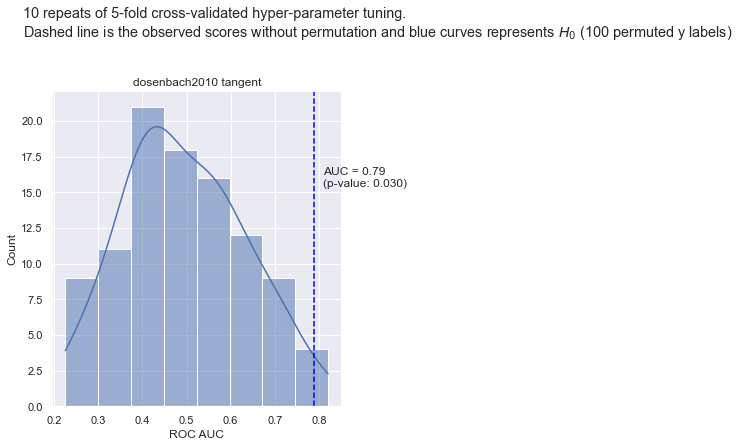

In [13]:

g = sns.displot(rnd_scores, kde=True)
g.set(xlabel='ROC AUC')
g.ax.set_title('{} {}'.format(ATLAS, CONNECTIVITY_MEASURE))

plt.axvline(obs_score, ls='--', color='blue')


plt.text(x=obs_score + .02,
        y=plt.gca().get_ylim()[1] * .7,
        s=f'AUC = {obs_score:.2f}\n(p-value: {obs_pvalue:.3f})')

plt.suptitle(f'{cv.n_repeats} repeats of 5-fold cross-validated hyper-parameter tuning.\n'
             f'Dashed line is the observed scores without permutation '
             f'and blue curves represents $H_0$ (100 permuted y labels)',
             y=1.2, x=.08, ha='left')
plt.show()

In [14]:
X_df.columns.get_level_values(0).unique().to_list()

['sensorimotor',
 'occipital',
 'fronto-parietal',
 'cingulo-opercular',
 'cerebellum',
 'default']

Now, we visualize the factor loadings against the features.

In [15]:
_network_names = X_df.columns.get_level_values(0).unique().to_series()
# print(_network_names)
palt = dict(zip(
  _network_names,
  sns.color_palette('Set1', len(_network_names))))

network_colors = pd.Series(_network_names).apply(lambda x: pd.Series((palt[x], x)))
network_colors.rename(columns={0:'color', 1:'network'}, inplace=True)
network_colors.reset_index(drop=True, inplace=True)
network_colors.drop_duplicates(inplace=True)
network_colors.set_index('network', inplace=True)


feature_colors = {}
for network,regions in factors_model.items():
  for region in regions:
    feature_colors[region] = network_colors.loc[network, 'color']

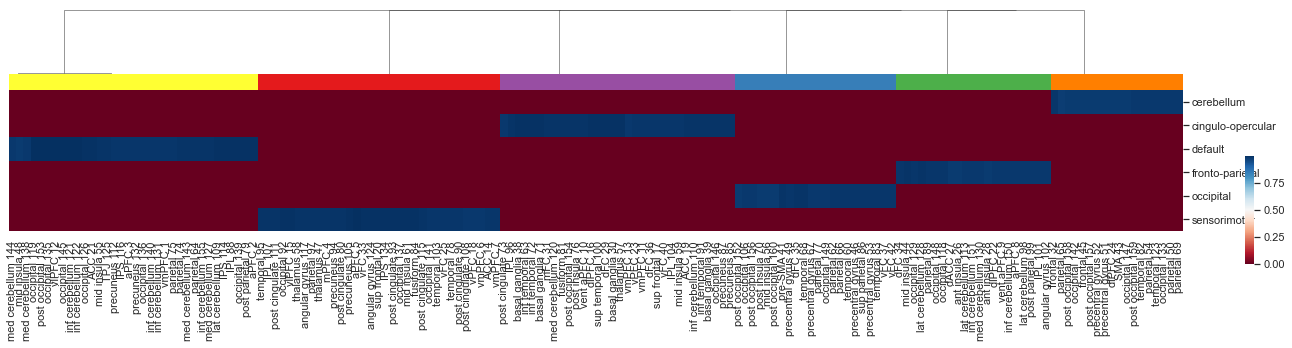

In [16]:
cfa_loadings = pd.DataFrame(
  cfa.loadings_,
  index=X_df.columns.get_level_values(1),
  columns=list(factors_model.keys())
)

# fig, ax = plt.subplots(figsize=(30,3))
# sns.heatmap(fa_loadings.T, ax=ax)


g = sns.clustermap(cfa_loadings.T, figsize=(25,5),
               row_cluster=False, col_cluster=True,
               cbar_pos=(.975, .25, 0.005, 0.3),
               cmap='RdBu',
               xticklabels=1,
               colors_ratio=.07,
               dendrogram_ratio=.3,
               col_colors=list(feature_colors.values()),)

g.ax_row_dendrogram.set_visible(False)

# to rotate y labels
# g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), rotation=45, ha='right', fontsize=10)

plt.show()

We can also report the importance of each factor, that is coefficient of the linear SVM classifier we trained above.


It can be seen as a measure of the importance of each factor to the classification task.

In [17]:
for i, (net, feats) in enumerate(factors_model.items()):
  coef = opt.best_estimator_['clf'].coef_[0][i]
  print(f'{net}:\n'
        f'\tSVM coef: {coef:.2f}\n'
        f'\tfeatures: {", ".join(feats)}')

cerebellum:
	SVM coef: 2.05
	features: inf cerebellum 110, med cerebellum 120, med cerebellum 144, inf cerebellum 131, inf cerebellum 140, med cerebellum 127, med cerebellum 138, med cerebellum 143, lat cerebellum 109, inf cerebellum 121, inf cerebellum 122, inf cerebellum 155, inf cerebellum 150, inf cerebellum 151, med cerebellum 130, lat cerebellum 113, lat cerebellum 128, lat cerebellum 98
cingulo-opercular:
	SVM coef: -3.64
	features: ACC 19, basal ganglia 30, basal ganglia 38, post insula 76, precuneus 87, fusiform 81, basal ganglia 39, mFC 31, thalamus 57, vFC 40, sup temporal 100, mid insula 59, basal ganglia 71, TPJ 125, aPFC 8, parietal 89, mid insula 44, dACC 27, ant insula 26, angular gyrus 102, ant insula 28, temporal 78, parietal 97, thalamus 58, mid insula 61, vFC 33, vPFC 18, temporal 103, vFC 25, thalamus 47, temporal 95, post cingulate 80
default:
	SVM coef: -2.88
	features: post cingulate 73, vmPFC 11, occipital 146, inf temporal 63, vmPFC 13, precuneus 85, sup front

### Explain the model

#### SHAP

We can explain the contribution of each factor to the classification score by plotting their SHAP values.

100%|██████████| 500/500 [00:16<00:00, 30.80it/s]


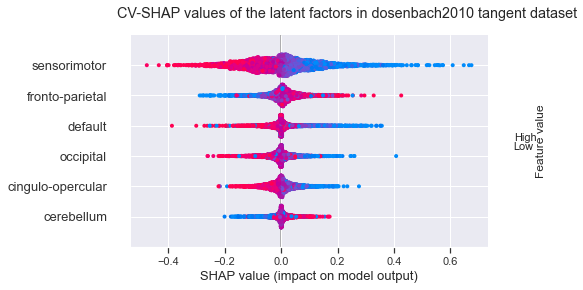

In [18]:
import shap

cv = model_selection.RepeatedStratifiedKFold(n_splits=5, n_repeats=100)
n_splits = cv.get_n_splits(X, y)

shap_values_cv = []
expected_value_cv = []
X_test_indices_cv = []
y_test_cv = []
y_pred_cv = []

model = opt.best_estimator_

for train, test in tqdm(cv.split(X, y), total=n_splits):

  model.fit(X_cfa[train], y[train])
  y_pred = model.predict(X_cfa[test])
  explainer = shap.Explainer(model.predict_proba,
                            X_cfa[train],
                            feature_names=list(factors_model.keys()))

  shap_values = explainer(X_cfa[test])

  shap_values_cv.append(shap_values)
  # expected_value_cv.append(explainer.expected_value)
  X_test_indices_cv.append(test)
  y_test_cv.append(y[test])
  y_pred_cv.append(y_pred)

# merge CV data
y_test = np.hstack(y_test_cv)
y_pred = np.hstack(y_pred_cv)

# merge CV SHAPs
shap_values = shap.Explanation(
  values = np.vstack([sh.values[...,1] for sh in shap_values_cv]),
  base_values = np.hstack([sh.base_values[...,1] for sh in shap_values_cv]),
  data = np.vstack([sh.data for sh in shap_values_cv]),
  feature_names=shap_values_cv[0].feature_names,
  compute_time=np.sum([sh.compute_time for sh in shap_values_cv]),
  output_names=y_encoder.classes_,
  output_indexes=y_pred,
)


shap.plots.beeswarm(shap_values, show=False)
plt.suptitle('CV-SHAP values of the latent factors in {} {} dataset'.format(ATLAS, CONNECTIVITY_MEASURE))
plt.show()

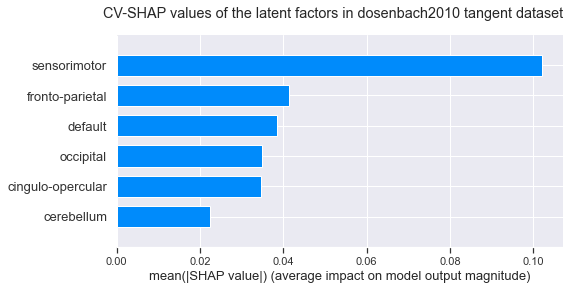

In [189]:
shap.summary_plot(deepcopy(shap_values), plot_type='bar', show=False)

plt.suptitle('CV-SHAP values of the latent factors in {} {} dataset'.format(ATLAS, CONNECTIVITY_MEASURE))
plt.show()

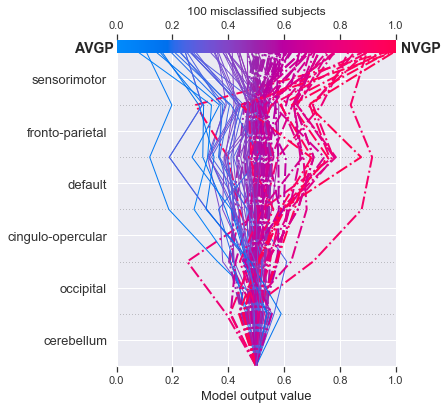

In [184]:
# Decision plots

n_samples = 100
select_mask = np.where(y_pred == y_test)[0]     # correctly classified
# select_mask = np.where(y_pred != y_test)[0]   # misclassified
# select_mask = np.where(y_pred)[0]             # predicted class
# select_mask = np.where(y_test)[0]             # true class

select_mask = shap.utils.sample(select_mask, n_samples, random_state=1)

highlight_mask = (y_test[select_mask] == 1)

plt.figure(figsize=(5,6))

shap.plots.decision(.5,
                    shap_values.values[select_mask],
                    # link='logit',
                    # feature_order='hclust',
                    # highlight=misclassified,
                    # ignore_warnings=True,
                    # legend_labels=legend_labels(highlight_mask),
                    highlight=highlight_mask,
                    xlim=(0,1),
                    auto_size_plot=False,
                    show=False,
                    title='100 misclassified subjects',
                    feature_names = list(factors_model.keys()))

plt.gca().text(-.15,6.01, 'AVGP', clip_box=True, fontdict=dict(fontsize=14, weight='bold'))
plt.gca().text(1.02,6.01, 'NVGP', clip_box=True, fontdict=dict(fontsize=14, weight='bold'))

plt.show()

#### Permutation Importance

Another feature importance method is the permutation analysis, where we permute the feature values and compute the classification score. The effect of a feature on the classification is then plotted.

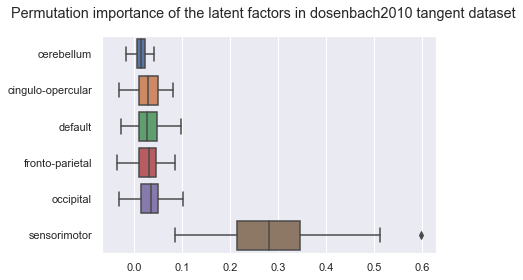

In [188]:
from sklearn.inspection import permutation_importance

opt.best_estimator_.fit(X_cfa, y)
perm_imp_result = permutation_importance(opt.best_estimator_, X_cfa, y, 
                                         n_repeats=100,
                                         scoring='roc_auc', n_jobs=-1)

perm_sorted_idx = perm_imp_result.importances_mean.argsort()

perm_df = pd.DataFrame(perm_imp_result.importances[perm_sorted_idx].T,
             columns=factors_model.keys())
sns.boxplot(
    data=perm_df,
    orient='horizontal',
#     labels=feature_names[perm_sorted_idx],
)

plt.suptitle('Permutation importance of the latent factors in {} {} dataset'.format(ATLAS, CONNECTIVITY_MEASURE))
plt.show()

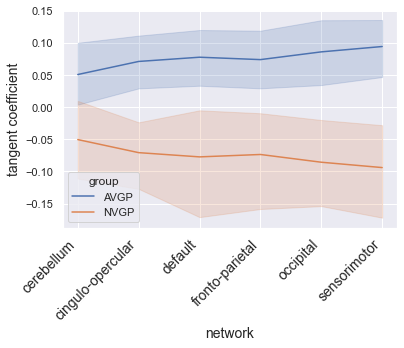

In [186]:
# X2 = pd.DataFrame(X_cfa.values, columns=X_cfa.columns)
X_debug = pd.DataFrame(X_cfa, columns=(factors_model.keys()))
y_debug = y_encoder.inverse_transform(y)
X_debug.loc[:,'y'] = y_debug
plotting_data = X_debug.melt(id_vars=['y']).rename(columns={'variable':'factor', 'value':'coef', 'y': 'group'})

g = sns.lineplot(x='factor', y='coef', hue='group', data=plotting_data)

plt.xticks(rotation=45, ha='right', fontsize=14)
plt.ylabel('tangent coefficient', fontsize=14)
plt.xlabel('network', fontsize=14)
plt.show()

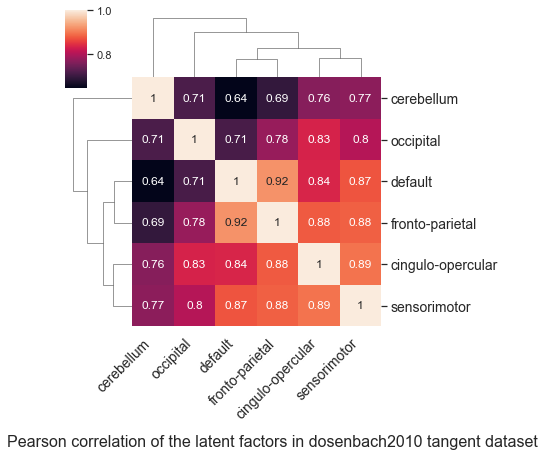

In [22]:
X_cfa_corr = pd.DataFrame(X_cfa).corr()
X_cfa_corr.columns = factors_model.keys()
X_cfa_corr.index = factors_model.keys()

g = sns.clustermap(X_cfa_corr, figsize=(6,6), annot=True, robust=True)

g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), rotation=45, ha='right', fontsize=14)
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), fontsize=14)


plt.suptitle('Pearson correlation of the latent factors in {} {} dataset'.format(ATLAS, CONNECTIVITY_MEASURE), y=0, fontsize=16)
plt.show()

In [23]:
xi = np.zeros((6,6))
n = 6

for i, source in enumerate(X_cfa.T):
  for j, target in enumerate(X_cfa.T):
    target = target[np.argsort(source, kind='quicksort')]
    _, inverse, counts = np.unique(target, return_inverse=True, return_counts=True)
    right = np.cumsum(counts)[inverse]
    left = np.cumsum(np.flip(counts))[(counts.size - 1) - inverse]
    coef = 1. - 0.5 * np.abs(np.diff(right)).sum() / np.mean(left * (n - left))
    xi[i, j] = coef

xi[np.diag_indices(6)] = 0.0

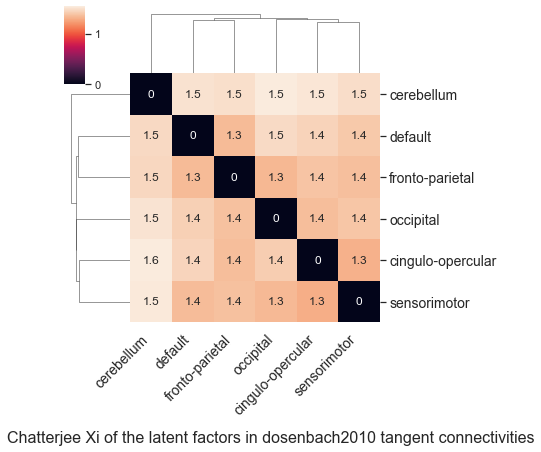

In [24]:
from python.acnets.connectome._chatterjee import chatterjee_xicoef

X_cfa_corr = pd.DataFrame(xi)
X_cfa_corr.columns = factors_model.keys()
X_cfa_corr.index = factors_model.keys()

g = sns.clustermap(X_cfa_corr, figsize=(6,6), annot=True, robust=True)

g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), rotation=45, ha='right', fontsize=14)
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), fontsize=14)


plt.suptitle('Chatterjee Xi of the latent factors in {} {} connectivities'.format(ATLAS, CONNECTIVITY_MEASURE), y=0, fontsize=16)
plt.show()